In [1]:
import sys
sys.path.append('../Automatic-Circuit-Discovery/')
sys.path.append('../tracr/')
sys.path.append('..')
import os
import re
import json
import pandas as pd
import torch as t
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.style.use('seaborn-v0_8-paper')


device = t.device("cuda" if t.cuda.is_available() else "CPU")
print(device)

cuda


In [2]:
'''from transformer_lens import HookedTransformer
from ioi_dataset import IOIDataset, format_prompt, make_table
from acdc.TLACDCExperiment import TLACDCExperiment

model = HookedTransformer.from_pretrained(
    'gpt2-small',
    center_writing_weights=False,
    center_unembed=False,
    fold_ln=False,
    device=device,
)
model.set_use_hook_mlp_in(True)
model.set_use_split_qkv_input(True)
model.set_use_attn_result(True)

N = 25
clean_dataset = IOIDataset(
    prompt_type='mixed',
    N=N,
    tokenizer=model.tokenizer,
    prepend_bos=False,
    seed=1,
    device=device
)
corr_dataset = clean_dataset.gen_flipped_prompts('ABC->XYZ, BAB->XYZ')

def ave_logit_diff(
    logits,
    ioi_dataset,
    per_prompt = False
):
    '''
        #Return average logit difference between correct and incorrect answers
    '''
    # Get logits for indirect objects
    io_logits = logits[range(logits.size(0)), ioi_dataset.word_idx['end'], ioi_dataset.io_tokenIDs]
    s_logits = logits[range(logits.size(0)), ioi_dataset.word_idx['end'], ioi_dataset.s_tokenIDs]
    # Get logits for subject
    logit_diff = io_logits - s_logits
    return logit_diff if per_prompt else logit_diff.mean()

with t.no_grad():
    clean_logits = model(clean_dataset.toks)
    corrupt_logits = model(corr_dataset.toks)
    clean_logit_diff = ave_logit_diff(clean_logits, clean_dataset).item()
    corrupt_logit_diff = ave_logit_diff(corrupt_logits, corr_dataset).item()

def ioi_metric(
    logits,
    corrupted_logit_diff = corrupt_logit_diff,
    clean_logit_diff = clean_logit_diff,
    ioi_dataset = clean_dataset
 ):
    patched_logit_diff = ave_logit_diff(logits, ioi_dataset)
    return (patched_logit_diff - corrupted_logit_diff) / (clean_logit_diff - corrupted_logit_diff)

exp = TLACDCExperiment(
    model=model,
    threshold=[0],
    ds=clean_dataset.toks,
    ref_ds=corr_dataset.toks,
    metric=ioi_metric,
    online_cache_cpu=False,
    corrupted_cache_cpu=False,
)
'''

IndentationError: unexpected indent (196300989.py, line 34)

In [2]:
from transformer_lens import HookedTransformer
model = HookedTransformer.from_pretrained(
    'gpt2-small',
    center_writing_weights=False,
    center_unembed=False,
    fold_ln=False,
    device=device,
)
model.set_use_hook_mlp_in(True)
model.set_use_split_qkv_input(True)
model.set_use_attn_result(True)


with open(f'acdcpp_edges_acdcpp_scores.json', 'r') as f:
    acdcpp_scores = json.load(f)
    
#all_edges = parse_relevant_edges(exp)
acdcpp_scores = acdcpp_scores['0.0027062']
all_edges = set(acdcpp_scores.keys())
from acdc.ioi.utils import get_ioi_true_edges

true_edges_tuples = get_ioi_true_edges(model)
true_edges = set()
replace_parens = lambda tup: str(tup).replace('(', '[').replace(')', ']').replace('[None,]', '[None]').replace('None', ':')

for child_name, child_idx, parent_name, parent_idx in true_edges_tuples:
    true_edges.add(f'{child_name}{replace_parens(child_idx)}{parent_name}{replace_parens(parent_idx)}')

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


In [3]:
with open('../Automatic-Circuit-Discovery/experiments/results/plots_data/acdc-ioi-logit_diff-False-0.json', 'r') as f:
    acdc_ioi_metric = json.load(f)
with open('../Automatic-Circuit-Discovery/experiments/results/plots_data/acdc-ioi-kl_div-False-0.json', 'r') as f:
    acdc_kl_metric = json.load(f)

In [4]:
def edges_after_acdcpp(thresh):
    edges = set()
    for edge, attr in acdcpp_scores.items():
        # If attr < thresh, would've been removed
        if abs(attr) >= thresh:
            edges.add(edge)
    return edges

data = {
    'Threshold': [0],
    'ACDCpp TPR': [1],
    'ACDCpp TNR': [0],
    'ACDCpp FPR': [1],
    'ACDCpp FNR': [0],
#     'TPR': [1],
#     'TNR': [0],
#     'FPR': [1],
#     'FNR': [0],
}

for thresh in np.logspace(-6, 0, num=50, base=5):
    data['Threshold'].append(float(thresh))
    # Variables prefixed with pp_ are after ADCDCpp only
    pp_edges = edges_after_acdcpp(float(thresh))
    #edges = set(acdc_scores[thresh].keys())
    
    pp_tp = len(pp_edges.intersection(true_edges))
    pp_tn = len((all_edges - true_edges).intersection(all_edges - pp_edges))
    pp_fp = len(pp_edges - true_edges)
    pp_fn = len(true_edges - pp_edges)

#     tp = len(edges.intersection(true_edges))
#     tn = len((all_edges - true_edges).intersection(all_edges - edges))
#     fp = len(edges - true_edges)
#     fn = len(true_edges - edges)

    pp_tpr = pp_tp / (pp_tp + pp_fn)
    pp_tnr = pp_tn / (pp_tn + pp_fp)
    pp_fpr = 1 - pp_tnr
    pp_fnr = 1 - pp_tpr

#     tpr = tp / (tp + fn)
#     tnr = tn / (tn + fp)
#     fpr = 1 - tnr
#     fnr = 1 - tpr

    data['ACDCpp TPR'].append(pp_tpr)
    data['ACDCpp TNR'].append(pp_tnr)
    data['ACDCpp FPR'].append(pp_fpr)
    data['ACDCpp FNR'].append(pp_fnr)

#     data['TPR'].append(tpr)
#     data['TNR'].append(tnr)
#     data['FPR'].append(fpr)
#     data['FNR'].append(fnr)

df = pd.DataFrame(data)
# Add thresh inf to end of df
row = [np.inf, 0, 1, 0, 1]# 0, 1, 0, 1]
df.loc[len(df)] = row

In [26]:
df

,Threshold,ACDCpp TPR,ACDCpp TNR,ACDCpp FPR,ACDCpp FNR
0,0.000000,1.000000,0.000000,1.000000,0.000000
1,0.000064,0.986737,0.170244,0.829756,0.013263
2,0.000078,0.984085,0.194844,0.805156,0.015915
3,0.000095,0.981432,0.222670,0.777330,0.018568
4,0.000116,0.978780,0.254529,0.745471,0.021220
5,0.000141,0.974359,0.286605,0.713395,0.025641
6,0.000171,0.972591,0.324203,0.675797,0.027409
7,0.000209,0.967286,0.362762,0.637238,0.032714
8,0.000254,0.960212,0.405354,0.594646,0.039788
9,0.000310,0.957560,0.447357,0.552643,0.042440


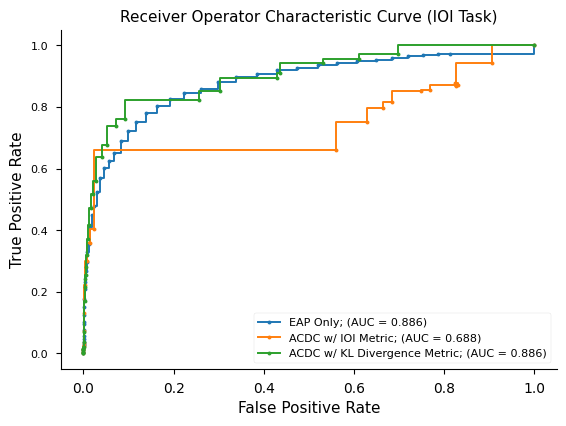

In [18]:
# Calculate AUC using trapezoidal rule
from sklearn.metrics import auc

from scipy import integrate

acdcpp_auc = round(abs(auc(df['ACDCpp FPR'], df['ACDCpp TPR'])), 3)
acdc_ioi_auc = round(
    abs(
        1 - integrate.simpson(
            acdc_ioi_metric['trained']['random_ablation']['ioi']['logit_diff']['ACDC']['edge_fpr'],
            acdc_ioi_metric['trained']['random_ablation']['ioi']['logit_diff']['ACDC']['edge_tpr']
        )
    ), 3)
acdc_kl_auc = round(
    abs(
        auc(
            acdc_kl_metric['trained']['random_ablation']['ioi']['kl_div']['ACDC']['edge_fpr'],
            acdc_kl_metric['trained']['random_ablation']['ioi']['kl_div']['ACDC']['edge_tpr']
        )
    ), 3)

plt.step(df['ACDCpp FPR'], df['ACDCpp TPR'], marker='.', label=f'EAP Only; (AUC = {acdcpp_auc})')
plt.step(
    acdc_ioi_metric['trained']['random_ablation']['ioi']['logit_diff']['ACDC']['edge_fpr'],
    acdc_ioi_metric['trained']['random_ablation']['ioi']['logit_diff']['ACDC']['edge_tpr'],
    marker='.', 
    label=f'ACDC w/ IOI Metric; (AUC = {acdc_ioi_auc})'
)
plt.step(
    acdc_kl_metric['trained']['random_ablation']['ioi']['kl_div']['ACDC']['edge_fpr'],
    acdc_kl_metric['trained']['random_ablation']['ioi']['kl_div']['ACDC']['edge_tpr'],
    marker='.', 
    label=f'ACDC w/ KL Divergence Metric; (AUC = {acdc_kl_auc})'
)
plt.xlabel('False Positive Rate', size=11)
plt.ylabel('True Positive Rate', size=11)
plt.title('Receiver Operator Characteristic Curve (IOI Task)', size=11)
plt.legend()
plt.savefig('IOI_ROC_Curve.pdf')

In [7]:
mpl.rcParams["axes.prop_cycle"]

'#1f77b4'
'#ff7f0e'
'#2ca02c'
'#d62728'
'#9467bd'
'#8c564b'
'#e377c2'
'#7f7f7f'
'#bcbd22'
'#17becf'


In [6]:
df['pp_Youdens_J'] = df['ACDCpp TPR'] - df['ACDCpp FPR']
best_threshold_pp = df.loc[df['pp_Youdens_J'].idxmax(), 'Threshold']
print(
    best_threshold_pp, 
    df[df['Threshold'] == best_threshold_pp]['ACDCpp FPR'].iloc[0], 
    df[df['Threshold'] == best_threshold_pp]['ACDCpp TPR'].iloc[0]
)

0.0018246465845408641 0.16341977912892414 0.8037135278514589


In [7]:
import re
head_pttn = re.compile("^([0-9]+).attn.hook_result\[(:, )+([0-9]+)\]$")
ioi_edges_to_job = {
    'Previous Token': set(['2.2', '4.11']),
    'Duplicate Token': set(['0.1','3.0', '0.10']),
    'Induction': set(['5.5', '6.9', '5.8', '5.9']),
    'S-inhibition': set(['7.3', '7.9', '8.6', '8.10']),
    'Negative Name Mover': set(['10.7', '11.10']),
    'Name Mover': set(['9.9', '9.6', '10.0', '9.0', '9.7', '10.1', '10.2', '10.6', '10.10', '11.2', '11.9']),
    #'Backup Name Mover': set([])
}

def find_head_job(head_name):
    head_job = None
    for job, heads in ioi_edges_to_job.items():
        if head_name in heads:
            head_job = job
            break
    return head_job

def job_from_edge(edge):
    sender_node = edge.split('blocks.')[-1]
    head_match = head_pttn.search(sender_node)
    if head_match: 
        sender_layer = head_match.group(1)
        sender_head = head_match.group(3)
        return find_head_job(f'{sender_layer}.{sender_head}')
    return "Other"
            
    
scores_data = {'attr': [], 'is_in_circuit': [], 'circuit_part': []}
for edge, attr in acdcpp_scores.items():
    scores_data['attr'].append(attr)
    if edge in true_edges:
        scores_data['is_in_circuit'].append(True)
        scores_data['circuit_part'].append(job_from_edge(edge))
    else:
        scores_data['is_in_circuit'].append(False)
        scores_data['circuit_part'].append("Not In Circuit")
        
scores_df = pd.DataFrame(scores_data)

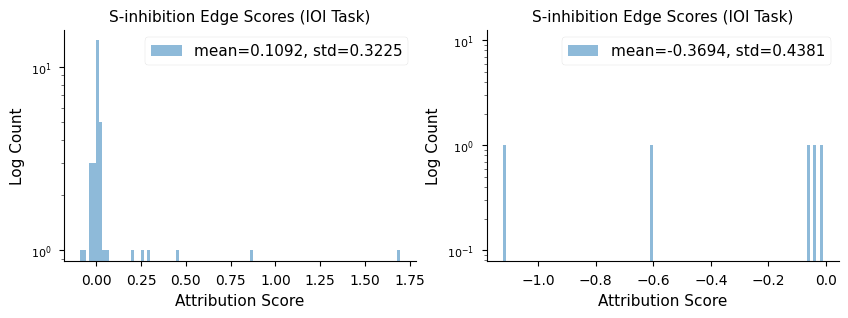

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
job_attrs = scores_df[scores_df['circuit_part'] == 'Name Mover']['attr']
#print(job_attrs)
mean = np.mean(job_attrs)
std = np.std(job_attrs)
ax[0].hist(job_attrs, 
    bins=100, 
    alpha=0.5, 
    log=True,
    label=f'mean={mean:.4f}, std={std:.4f}')

# Set the title and labels
ax[0].set_title(f'{job} Edge Scores (IOI Task)', size=11)
ax[0].set_xlabel('Attribution Score', size=11)
ax[0].set_ylabel('Log Count', size=11)
# Add a legend
ax[0].legend(loc='upper right', fontsize = 11)

job_attrs = scores_df[scores_df['circuit_part'] == 'Negative Name Mover']['attr']
#print(job_attrs)
mean = np.mean(job_attrs)
std = np.std(job_attrs)
ax[1].hist(job_attrs, 
    bins=100, 
    alpha=0.5, 
    log=True,
    label=f'mean={mean:.4f}, std={std:.4f}')

# Set the title and labels
ax[1].set_title(f'{job} Edge Scores (IOI Task)', size=11)
ax[1].set_xlabel('Attribution Score', size=11)
ax[1].set_ylabel('Log Count', size=11)
# Add a legend
ax[1].legend(loc='upper right', fontsize = 11)
fig.savefig('IOI_Name Movers_Hist.pdf')

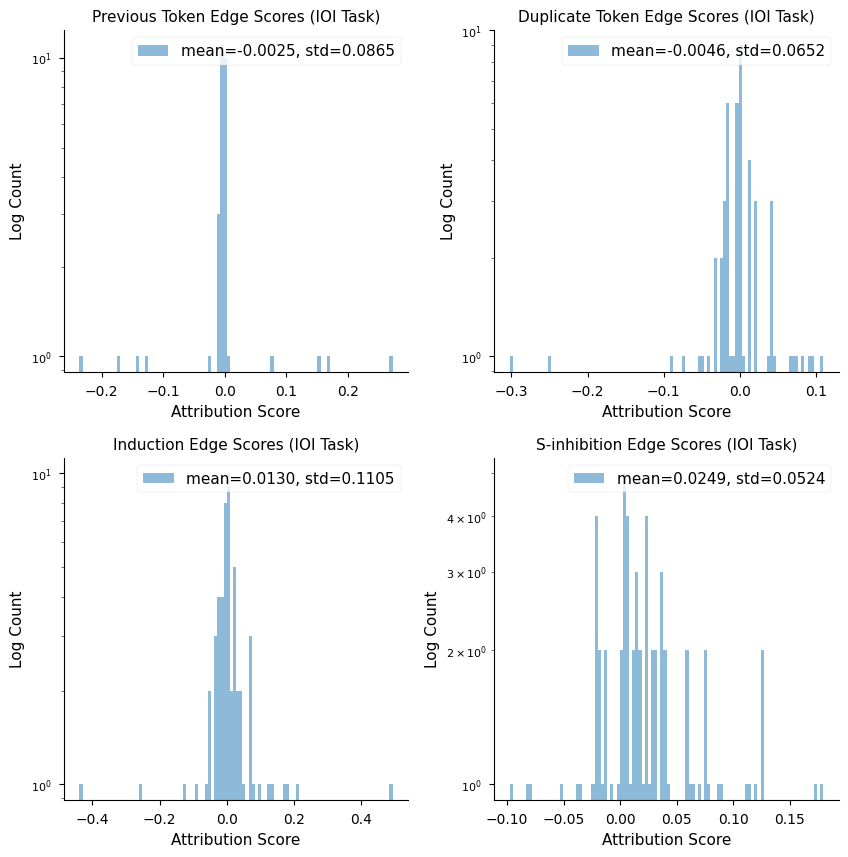

In [17]:
import itertools
# Hist separating head functions
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.25, wspace=0.25)
exclude = set(['Not In Circuit', 
               'Other', 
               'Negative Name Mover',
               'Name Mover',
               ])
plt.rc('xtick', labelsize=10) 

for job, (row, col) in zip(ioi_edges_to_job.keys(), list(itertools.product([0, 1], [0,1]))):
    if job in exclude:
        continue
    job_attrs = scores_df[scores_df['circuit_part'] == job]['attr']
    #print(job_attrs)
    mean = np.mean(job_attrs)
    std = np.std(job_attrs)
    ax[row][col].hist(job_attrs, 
        bins=100, 
        alpha=0.5, 
        log=True,
        label=f'mean={mean:.4f}, std={std:.4f}')
    
    # Set the title and labels
    ax[row][col].set_title(f'{job} Edge Scores (IOI Task)', size=11)
    ax[row][col].set_xlabel('Attribution Score', size=11)
    ax[row][col].set_ylabel('Log Count', size=11)
    # Add a legend
    ax[row][col].legend(loc='upper right', fontsize = 11)

# Show the plot
plt.show()
fig.savefig('IOI_Remainder_Hist.pdf')

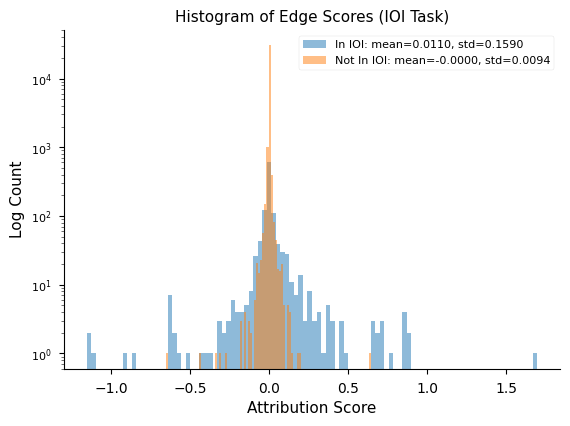

In [29]:
# Create a figure and axis
fig, ax = plt.subplots()

# Calculate the mean and standard deviation of scores for positive and negative cases
positive_scores = scores_df[scores_df['is_in_circuit'] == True]['attr']
negative_scores = scores_df[scores_df['is_in_circuit'] == False]['attr']

positive_mean = np.mean(positive_scores)
positive_std = np.std(positive_scores)

negative_mean = np.mean(negative_scores)
negative_std = np.std(negative_scores)

# Plot the distribution of scores for positive and negative cases
ax.hist(positive_scores, 
        bins=100, 
        alpha=0.5, 
        log=True,
        label=f'In IOI: mean={positive_mean:.4f}, std={positive_std:.4f}')
ax.hist(negative_scores, 
        bins=100, 
        alpha=0.5, 
        log=True,
        label=f'Not In IOI: mean={negative_mean:.4f}, std={negative_std:.4f}')

# Set the title and labels
ax.set_title('Histogram of Edge Scores (IOI Task)', size=11)
ax.set_xlabel('Attribution Score', size=11)
ax.set_ylabel('Log Count', size=11)

# Add a legend
ax.legend(loc='upper right', fontsize = 8)

# Show the plot
plt.show()
fig.savefig('IOI_Hist_Scores.pdf')